# Train LSTM model to Enduro sequence games

## Load libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image
from enduro_lstm import *
import matplotlib.pyplot as plt
import time

## Set to GPU if available

In [2]:
use_gpu = input("Use GPU (y/n) ")
if use_gpu == 'y':
    use_gpu = True
else:
    use_gpu = False
    
device = conf_cuda(use_gpu)

Use GPU (y/n) y
GPU is available


In [3]:
if use_gpu:
    torch.cuda.empty_cache()

## Set configurations

In [4]:
obs = 'play'
if obs == 'zigzag':
    zigzag = True
else:
    zigzag = False
zigzag

False

In [5]:
data_path = r"../1-generate/data/"
n_epochs = 10000
hidden_neurons = 1000
stop_train = 1e-5

start_match = 45
end_match = 50

start_frame = 1
end_frame = 1000

In [6]:
model_name = f"{obs}_m{start_match}to{end_match}_f{start_frame}to{end_frame}_epoch{n_epochs}_H{hidden_neurons}"
newpath = f"models/" + model_name
if not os.path.exists(newpath):
    print(f"models/" + model_name + " created")
    os.makedirs(newpath)
else:
    print(f"models/" + model_name)
    print("ATTENTION! folder not created. Training informations will overwrite the existing one")

models/play_m45to50_f1to1000_epoch10000_H1000 created


## Load frames and targets

In [7]:
ACTIONS_LIST = get_actions_list(zigzag=zigzag)
ACTIONS_LIST

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [8]:
num_of_frames_arr = []
frames_arr = []
actions_arr = []

for m in range(start_match, end_match + 1):
    
    num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, m)
    frames = frames[start_frame - 1:end_frame]
    actions = actions[start_frame - 1:end_frame]
    
    action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
    actions = np.array(action_one_hot)
    actions = actions.reshape(len(actions), -1)
    
    frames_arr.append(frames)
    actions_arr.append(actions)
    num_of_frames_arr.append(end_frame - start_frame + 1) 

Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.


In [9]:
data = np.array(frames_arr)/255
targets = np.array(actions_arr)
num_of_frames_arr = np.array(num_of_frames_arr)

In [10]:
data = torch.tensor(data).float()
targets = torch.tensor(targets).float()

## Create model

In [11]:
model = Model(device=device, input_size=20400, output_size=len(ACTIONS_LIST), hidden_dim=hidden_neurons, n_layers=1)

In [12]:
# We'll also set the model to the device that we defined earlier (default is CPU)
if use_gpu:
    model.cuda()
    data = data.cuda() 
    targets = targets.cuda()

In [13]:
min_loss = 1e-05
# Define Loss, Optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters())

## Model train

In [14]:
train_loss_arr = np.array([])
train_acc_arr = np.array([])
valid_idx_arr = np.array([])
valid_loss_arr = np.array([])
valid_acc_arr = np.array([])

In [15]:
all_idx = np.arange(len(data))
start_time_processing = time.time()

# Training Run
loss_file = open(newpath + '/' + "loss_file.txt", "w")
first_time = True

best_loss = 1
first_epoch = True

for epoch in range(1, n_epochs + 1):
    
    for valid_idx in range(len(data)):

        train_idx = np.setdiff1d(all_idx, valid_idx)
        X_train = data[train_idx]
        Y_train = targets[train_idx]
        X_valid = data[valid_idx]
        Y_valid = targets[valid_idx]

        model.train()

        optimizer.zero_grad() # Clears existing gradients from previous epoch
        X_train.to(device)
        output, hidden = model(X_train)
        loss = criterion(output, Y_train.view(-1,len(ACTIONS_LIST)).float())
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        
        if epoch%10 == 0:
            
            train_loss_arr = np.append(train_loss_arr, loss.item())
            train_acc_arr  = np.append(train_acc_arr, get_acc(output, Y_train.reshape(-1, len(ACTIONS_LIST))))

            model.eval()
            
            output, hidden = model(X_valid.reshape(1, X_valid.shape[0], X_valid.shape[1]))
            loss = criterion(output, Y_valid.view(-1, len(ACTIONS_LIST)).float())
            
            valid_idx_arr = np.append(valid_idx_arr, int(valid_idx))
            valid_loss_arr = np.append(valid_loss_arr, loss.item())
            valid_acc_arr = np.append(valid_acc_arr, get_acc(output, Y_valid.reshape(-1, len(ACTIONS_LIST))))
            
            loss_file.write("Epoch: {}/{} - valid: {}---------------------------------\n".format(epoch, n_epochs, int(valid_idx_arr[-1])))
            loss_file.write("Train -> Loss: {:.15f} Acc: {:.15f}\n".format(train_loss_arr[-1], train_acc_arr[-1]))
            loss_file.write("Valid -> Loss: {:.15f} Acc: {:.15f}\n".format(valid_loss_arr[-1], valid_acc_arr[-1]))

            print("Epoch: {}/{} - valid: {}---------------------------------".format(epoch, n_epochs, int(valid_idx_arr[-1])))
            print("Train -> Loss: {:.15f} Acc: {:.15f}".format(train_loss_arr[-1], train_acc_arr[-1]))
            print("Valid -> Loss: {:.15f} Acc: {:.15f}".format(valid_loss_arr[-1], valid_acc_arr[-1]))

            if train_loss_arr[-1] < best_loss:
                state = { 'epoch': epoch + 1, 'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict(), 'losslogger': train_loss_arr[-1], }
                torch.save(state, newpath + '/' + model_name)
                best_loss = train_loss_arr[-1] 
            else:
                print("model not saved")

loss_file.write("--- %s seconds ---" % (time.time() - start_time_processing))
loss_file.close()
np.savez(newpath + '/' + "train_loss_arr", train_loss_arr)
np.savez(newpath + '/' + "valid_loss_table", valid_loss_arr)
np.savez(newpath + '/' + "valid_acc_table", valid_loss_mean_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

RuntimeError: CUDA out of memory. Tried to allocate 390.00 MiB (GPU 0; 2.00 GiB total capacity; 1.16 GiB already allocated; 6.55 MiB free; 1.16 GiB reserved in total by PyTorch)

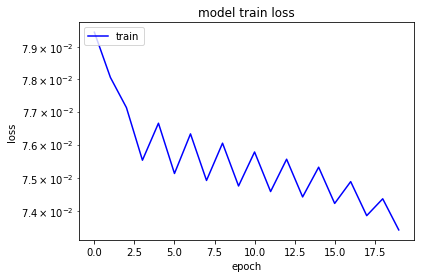

In [25]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.clf()
plt.plot(train_loss_arr, color='blue')
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'train_loss.png')

In [27]:
valid_loss_arr

array([0.07806029, 0.07888003, 0.07552649, 0.07706559, 0.07512809,
       0.0766156 , 0.07491969, 0.07629382, 0.07475504, 0.07601271,
       0.07458933, 0.07575096, 0.07442998, 0.07553601, 0.07423672,
       0.07530849, 0.07387631, 0.07483928, 0.07345744, 0.0743047 ])

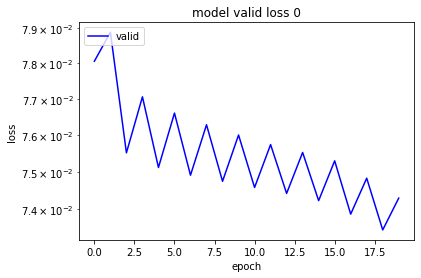

In [28]:
for seq in range(len(X_train)):
    # summarize history for loss
    plt.clf()
    plt.plot(valid_loss_arr, color='blue')
    plt.title('model valid loss ' + str(seq))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['valid'], loc='upper left')
    plt.yscale('log')
    plt.savefig(newpath + '/' + f'valid_loss_{seq}.png')